In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import sys
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from typing import Union, Tuple
from torch.utils.data import Dataset, DataLoader
import cv2

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Model(nn.Module):
    def __init__(self,n):
        super(Model, self).__init__()   
        self.n = n
        self.conv_init = nn.Conv2d(in_channels=3, out_channels= 16,kernel_size=3, padding = 1) 
        self.conv_1 = nn.Conv2d(in_channels=16, out_channels= 16,kernel_size=3, padding = 1) 
        self.conv_1_last = nn.Conv2d(in_channels=16, out_channels= 16,kernel_size=3, stride = 2, padding = 1) 

        self.conv_2_change = nn.Conv2d(in_channels=16, out_channels= 32,kernel_size=3, padding = 1) 
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels= 32,kernel_size=3, padding = 1) 
        self.conv_2_last = nn.Conv2d(in_channels=32, out_channels= 32,kernel_size=3, stride = 2, padding = 1) 

        self.conv_3_change = nn.Conv2d(in_channels=32, out_channels= 64,kernel_size=3, padding = 1) 
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels= 64,kernel_size=3, padding = 1) 
        self.conv_3_last = nn.Conv2d(in_channels=64, out_channels= 64,kernel_size=3, stride = 2, padding = 1) 

        self.conv_skip0  = nn.Conv2d(in_channels=16,out_channels = 16,kernel_size = 1,stride=2)
        self.conv_skip1  = nn.Conv2d(in_channels=16,out_channels = 32,kernel_size = 1,stride=1)
        self.conv_skip2  = nn.Conv2d(in_channels=32,out_channels = 64,kernel_size = 1,stride=1)
        self.conv_skip11  = nn.Conv2d(in_channels=32,out_channels = 32,kernel_size = 1,stride=1)
        self.conv_skip21  = nn.Conv2d(in_channels=64,out_channels = 64,kernel_size = 1,stride=1)
        self.conv_skip12  = nn.Conv2d(in_channels=32,out_channels = 32,kernel_size = 1,stride=2)
        self.conv_skip22  = nn.Conv2d(in_channels=64,out_channels = 64,kernel_size = 1,stride=2)

        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)

        self.fc = nn.Linear(1024, 10)
        self.bn = nn.BatchNorm1d(10)
    def mse(self,x1,x2):
      return ((x1-x2)**2).mean()


    def forward(self, x):
      n = self.n
      x0 = F.relu(self.conv_init(x))
      x0 = self.bn16(x0)
    
      for j in range(2*n):
        x1 = self.bn16(F.relu(self.conv_1(x0)))
        x2 = self.bn16(F.relu(self.conv_1(x1)))
        x3 = self.bn16(F.relu(self.conv_1(x2+x0)))
        #print('MSE in skip1 {}'.format(self.mse(x2+x0,x3)))
        if j != 2*n-1:
          x4 = self.bn16(F.relu(self.conv_1(x3)))
          x0 = x4+x1
        else:
          x4 = self.bn16(F.relu(self.conv_1_last(x1)))
          x0 = x4+self.conv_skip0(x2)
          #print('MSE in skip2 {}'.format(self.mse(x4+self.conv_skip0(x2),x0)))

      for j in range(2*n):
        if j==0:
          x1 = self.bn32(F.relu(self.conv_2_change(x0)))
          x2 = self.bn32(F.relu(self.conv_2(x1)))
          x3 = self.bn32(F.relu(self.conv_2(x2+self.conv_skip1(x0))))
          #print('MSE in skip1 {}'.format(self.mse(x2+self.conv_skip1(x0),x3)))
        else:
          x1 = self.bn32(F.relu(self.conv_2(x0)))
          x2 = self.bn32(F.relu(self.conv_2(x1)))
          x3 = self.bn32(F.relu(self.conv_2(x2+self.conv_skip11(x0))))
          #print('MSE in skip1 {}'.format(self.mse(x2+self.conv_skip11(x0),x3)))
        if j != 2*n-1:
          x4 = self.bn32(F.relu(self.conv_2(x3)))
          x0 = x4+x2
          #print('MSE in skip2 {}'.format(self.mse(x2+x4,x0)))
        else:
          x4 = self.bn32(F.relu(self.conv_2_last(x1)))
          x0 = x4+self.conv_skip12(x2)
          #print('MSE in skip2 {}'.format(self.mse(x4+self.conv_skip12(x2),x0)))

      for j in range(2*n):
        if j ==0 :
          x1 = self.bn64(F.relu(self.conv_3_change(x0)))
          x2 = self.bn64(F.relu(self.conv_3(x1)))
          x3 = self.bn64(F.relu(self.conv_3(x2+self.conv_skip2(x0))))
          #print('MSE in skip1 {}'.format(self.mse(x2+self.conv_skip2(x0),x3)))
        else:
          x1 = self.bn64(F.relu(self.conv_3(x0)))
          x2 = self.bn64(F.relu(self.conv_3(x1)))
          x3 = self.bn64(F.relu(self.conv_3(x2+self.conv_skip21(x0))))
          #print('MSE in skip1 {}'.format(self.mse(x2+self.conv_skip21(x0),x3)))
        if j != 2*n-1:
          x4 = self.bn64(F.relu(self.conv_3(x3)))
          x0 = x4+x2
          #print('MSE in skip2 {}'.format(self.mse(x4+x2,x0)))
        else:
          x4 = self.bn64(F.relu(self.conv_3_last(x1)))
          x0 = x4+self.conv_skip22(x2)
          #print('MSE in skip2 {}'.format(self.mse(x4+self.conv_skip22(x2),x0)))
      x = x0.reshape([-1,1024])
      x = F.softmax(self.fc(x))
      x = self.bn(x)

      return x

In [ ]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  model.train()
  losses = []
  batch_total = len(train_loader)

  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      
      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())


      if batch_idx % 50 == 0:
        acc = float(samples_correct) / float(samples_total)

        if use_test:
          model.eval()

          test_x, test_y = next(iter(test_loader))
          if cuda:
            test_x, test_y = test_x.cuda(), test_y.cuda()
          test_output = model(test_x)
          test_loss = criterion(test_output, test_y)

          test_yhat = torch.argmax(test_output, dim=1)
          test_acc = float(torch.sum(test_yhat == test_y)) / float(len(test_y))
          
          model.train()

          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%} Test loss: {test_loss:.6f} Test acc: {test_acc:.2%}')
        else:
          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%}')

  return losses

In [ ]:
#model = Model(n=20)
#model = model.cuda()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
#model_losses = train(model, optimizer, (trainloader, testloader), max_epochs=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 2/3 Step: 350/391 Loss: 2.339865 Acc: 9.92% Test loss: 2.313329 Test acc: 10.16%

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

transform  = transforms.Compose([
                                 transforms.Pad(4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomCrop(32),
                                 transforms.ToTensor(),

                                 transforms.Normalize(mean, std)
])
train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

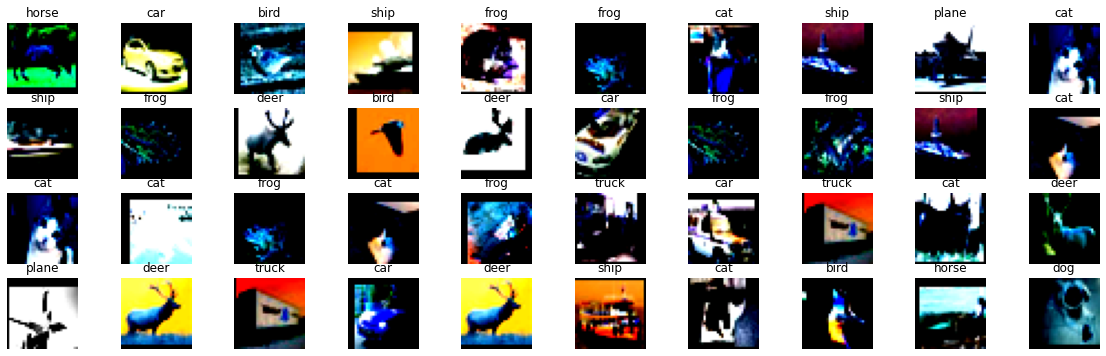

In [ ]:
x,y=next(iter(train_loader))
def show_random_images(X,y):
    num_samples = 40
    indices = np.random.choice(range(len(X)), num_samples)
    y=y[indices]
    sample_image = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(4, 10, i + 1)
        img = sample_image[i].permute(1, 2, 0)
        plt.imshow(cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2RGB))
        plt.title(classes[y[i].item()])
        plt.axis('off')
show_random_images(x,y)

In [ ]:
model = Model(n=3)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model_losses = train(model, optimizer, (trainloader, testloader), max_epochs=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 2/3 Step: 350/391 Loss: 2.322882 Acc: 9.85% Test loss: 2.311844 Test acc: 8.59%

## (a) Plot the filters of the first layer. What kind of features do they extract?
#Answer: As our model is not perfectly trained so it is difficult to tell what features these filters are extracting.


Filters Plot
Total convolutional layers: 16


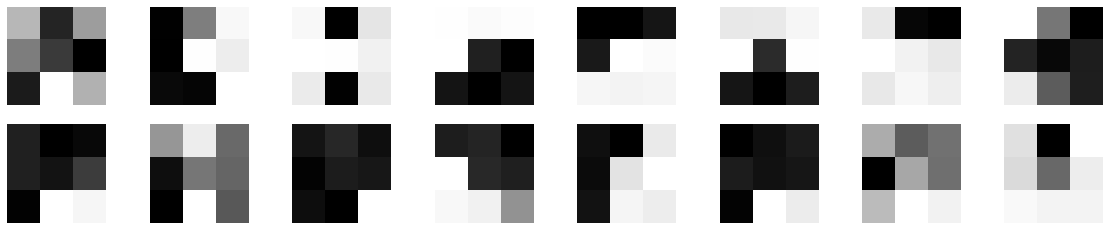

In [ ]:

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the conv layers in this list
# get all the model children as list
model_children = list(model.children())
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Filters Plot")
print(f"Total convolutional layers: {counter}")
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1)
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

## (b)For every two convolutions with skip connection calculate the MSE of the input of those
layer xin and the output xout: MSE(xin, xout). Does your network have layers that were
learned to be the identity?

yes there are mSE of 0 so the network identity sometimes

In [ ]:
model = Model(n=2)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model_losses = train(model, optimizer, (trainloader, testloader), max_epochs=3)

MSE in skip1 2.960233688354492
MSE in skip1 2.9884300231933594
MSE in skip1 2.8969054222106934
MSE in skip1 2.8651204109191895
MSE in skip2 0.0
MSE in skip1 2.1663126945495605
MSE in skip2 0.0
MSE in skip1 2.363680362701416
MSE in skip2 0.0
MSE in skip1 2.5352606773376465
MSE in skip2 0.0
MSE in skip1 2.5896949768066406
MSE in skip2 0.0
MSE in skip1 2.346334934234619
MSE in skip2 0.0
MSE in skip1 2.5031771659851074
MSE in skip2 0.0
MSE in skip1 2.568234920501709
MSE in skip2 0.0
MSE in skip1 2.5651371479034424
MSE in skip2 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Выходные данные были обрезаны до нескольких последних строк (5000).
MSE in skip1 2533.296875
MSE in skip2 0.0
MSE in skip1 6.076169967651367
MSE in skip1 8.021886825561523
MSE in skip1 8.588029861450195
MSE in skip1 8.69103717803955
MSE in skip2 0.0
MSE in skip1 619.0888061523438
MSE in skip2 0.0
MSE in skip1 288.4371643066406
MSE in skip2 0.0
MSE in skip1 300.2490234375
MSE in skip2 0.0
MSE in skip1 312.8216857910156
MSE in skip2 0.0
MSE in skip1 6027.77734375
MSE in skip2 0.0
MSE in skip1 1727.202392578125
MSE in skip2 0.0
MSE in skip1 2532.689697265625
MSE in skip2 0.0
MSE in skip1 2548.22314453125
MSE in skip2 0.0
MSE in skip1 6.087776184082031
MSE in skip1 8.00827407836914
MSE in skip1 8.595559120178223
MSE in skip1 8.654260635375977
MSE in skip2 0.0
MSE in skip1 621.554443359375
MSE in skip2 0.0
MSE in skip1 290.40826416015625
MSE in skip2 0.0
MSE in skip1 304.8742980957031
MSE in skip2 0.0
MSE in skip1 308.8426513671875
MSE in skip2 0.0
MSE in skip1 6435.4794921875
MSE in skip2 

In [ ]:
model = Model(n=2)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model_losses = train(model, optimizer, (trainloader, testloader), max_epochs=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 2/3 Step: 350/391 Loss: 2.284723 Acc: 15.56% Test loss: 2.351359 Test acc: 7.81%

In [ ]:
model = Model(n=2)
model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
model_losses = train(model, optimizer, (trainloader, testloader), max_epochs=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 2/3 Step: 350/391 Loss: 2.339312 Acc: 10.11% Test loss: 2.310202 Test acc: 7.81%

##(c) Is deeper always better? Provide some evidence for your answer and explain why that is the case.
It completely depends on training data and its size is, the CNN architecture is implemented.
 Adding layers unnecessarily to any CNN will increase your number of parameters only for the smaller dataset, say in 1000s (total 1000).
It’s true for some reasons that on adding more hidden layers, it will give more accuracy. 
This is true for larger datasets, as more layers with less stride factor will extract more features for your input data. 
In CNN, how you play with your architecture is completely dependent on what your requirement is and how your data is.
 Adding more layers will help you to extract more features. But we can do that upto a certain extent. 
 There is a limit. After that, instead of extracting features, we tend to ‘overfit’ the data. Increasing Unnecessary parameters will only overfit your network.
  Let's take a example of cat classification. If we increase number of layers then after some extents our model will start extracting the 'Bell' feature from cat. 
  So if any new animal who has 'Bell' may be detected as cat by our model.  